# Threshold, Dynamic Time Warping

## DW (2016.01.04)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import gitInformation
from neo.io.neuralynxio import NeuralynxIO
import quantities as pq
import sklearn
from scipy.interpolate import Rbf
import fastdtw
#import dtw

In [4]:
% matplotlib inline

In [5]:
gitInformation.printInformation()

Information about this notebook
Date: 2016-05-18
Python Version: 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Git directory: C:\Users\Dowa\Desktop\Hiwi\kt-2015-DSPHandsOn\.git
Current git SHA: 78e064d8c59671d29d15bb5b16bb485fec232a31
Remotes: origin, 
Current branch: master
origin remote URL: https://github.com/dowa4213/kt-2015-DSPHandsOn.git


In [6]:
# Session folder with all needed neuralynx files
sessionfolder = 'C:\\Users\\Dominik\\Documents\\GitRep\\kt-2015-DSPHandsOn\\MedianFilter\\Python\\07. Real Data'

In [7]:
# Loading the files with all datas and store them as a np.array
NIO = NeuralynxIO(sessiondir = sessionfolder, cachedir = sessionfolder)
block = NIO.read_block()
seg = block.segments[0]
analogsignal = seg.analogsignalarrays[0]

WindowsError: [Error 3] Das System kann den angegebenen Pfad nicht finden: 'C:\\Users\\Dominik\\Documents\\GitRep\\kt-2015-DSPHandsOn\\MedianFilter\\Python\\07. Real Data/*.*'

In [ ]:
csc = analogsignal.magnitude

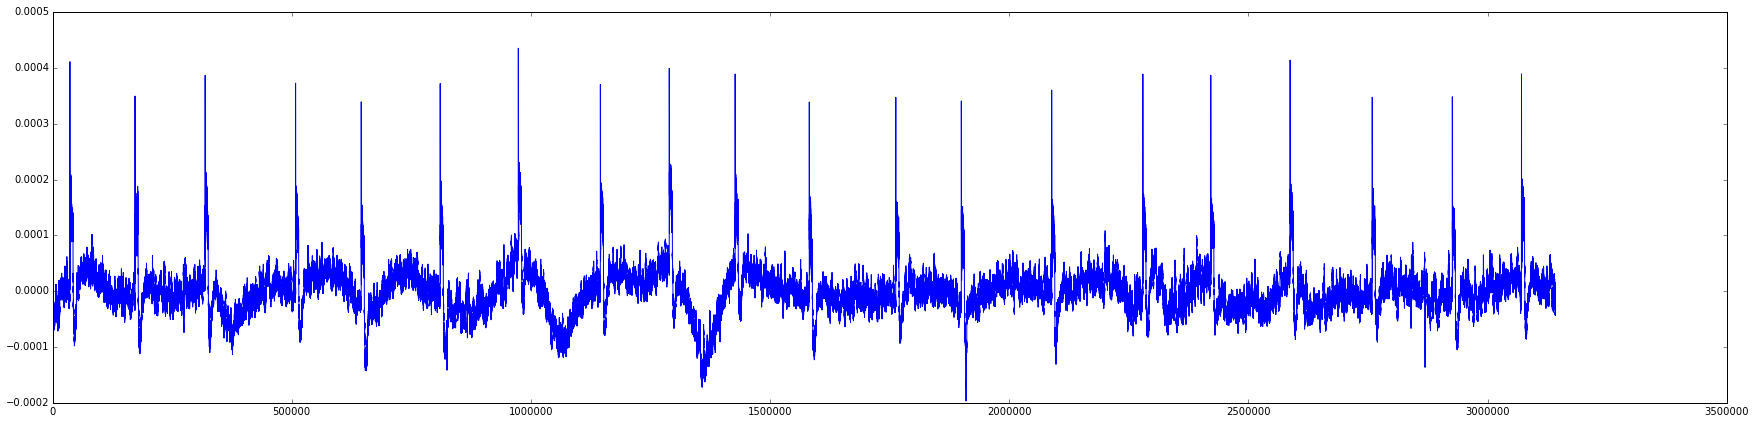

In [7]:
plt.figure(figsize=(30,7))
plt.plot(csc)

In [8]:
# Filter the Data with a median filter
filtered = medfilt(csc,45)
new_data = csc-filtered

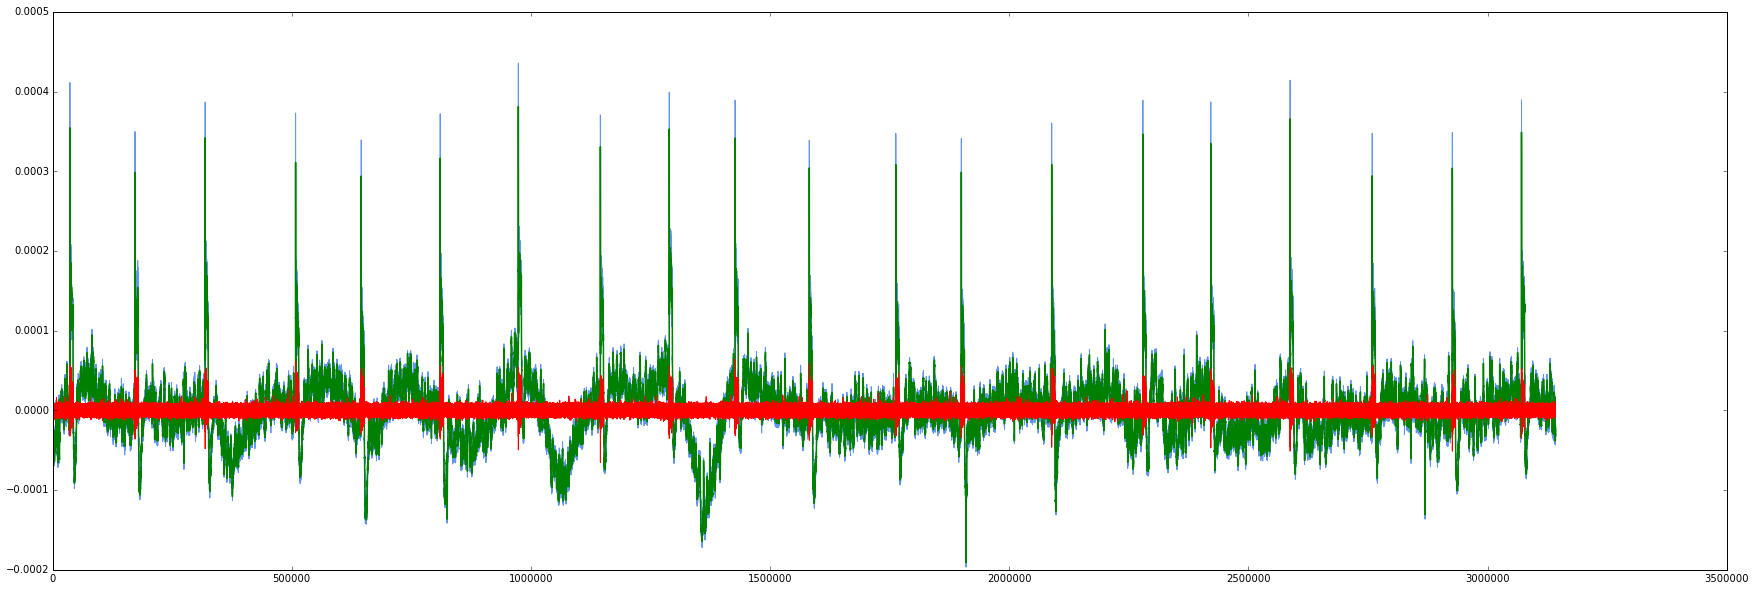

In [9]:
plt.figure(figsize=(30,10))
plt.plot(csc, color = 'cornflowerblue')
plt.plot(filtered, color = 'g', lw = 1.5)
plt.plot(new_data, color = 'r')

In [10]:
# Automatic Threshold calculation
threshold = 5*np.median(abs(new_data)/0.6745)

In [11]:
# Declaring counter and and dead time.
# Dead time: if the threshold is reached, we wait 50 samples until the threshhold can be
# activated again
count  = -1
count2 = 0
timer = 0
# Dictionary with all thresholded shapes
thresholds = {}
# Get the value in the new_data array:
for i in new_data:
    # Increment the counter (counter = position in the array)
    count += 1
    if i >= threshold:
        # check the thresholded window if some values are bigger then 0.00005
        temp = [i for i in new_data[count -6 : count + 18] if i >= 0.00005]
        # If no values are bigger then 0.00005 and the dead time is zero,
        # save the window in the dictionary 
        if len(temp) == 0 and timer == 0:
            # set the timer to 20, so 20 samples will be passed
            timer = 16
            # increment count2, for the array name
            count2 += 1
            thresholds["spike{0}".format(count2)] = new_data[count -6 : count + 18]
    elif timer > 0: 
        # Decrement the timer.
        timer -= 1
    else: 
        pass

In [12]:
# Transfrom the thresholded shpaes into a array
thresholds_array = np.zeros((24,len(thresholds)))
count = -1
for o in thresholds:
    count += 1
    thresholds_array[:,count] = thresholds[o]

In [13]:
x = np.arange(24)
x_new = np.linspace(0,24,240)
#Interpolate each spike with a Cubic RBF function
thresholds_interp = np.zeros((len(x_new),len(thresholds_array[1,:])))
for o in range(len(thresholds_array[1,:])):
    newfunc = Rbf(x, thresholds_array[:,o], function = 'cubic')
    thresholds_interp[:,o] = newfunc(x_new)

In [14]:
thresholds_norm = thresholds_array/float(thresholds_array.max())

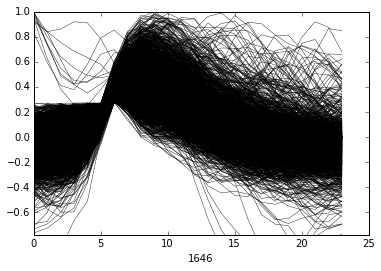

In [15]:
count = -1
for o in range(len(thresholds_interp[0,:])):
    count += 1
    fig = plt.figure(1)
    plt.axis([0,25,-0.78, 1.0])
    plt.plot( thresholds_norm[:,o], color = 'black', linewidth = 0.4)
    plt.xlabel(str(count))

In [16]:
template1 = thresholds_norm[:,29]
template2 = thresholds_norm[:,31]
template3 = thresholds_norm[:,75]
template4 = thresholds_norm[:,124]
template5 = thresholds_norm[:,175]

In [17]:
templates = np.zeros((1,24))

In [18]:
#templates[0,:] = template1
templates[0,:] = template1
#templates[2,:] = template3
#templates[3,:] = template4
#templates[4,:] = template5

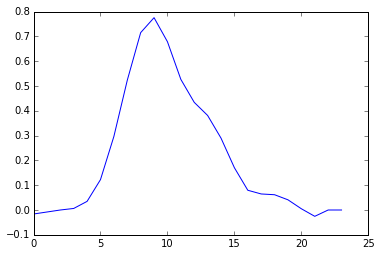

In [19]:
plt.plot(templates[0,:])
#plt.plot(templates[1,:])
#plt.plot(templates[2,:])
#plt.plot(templates[3,:])
#plt.plot(templates[4,:])
#plt.plot(templates[5,:])

## Comparison between fastDTW and normal DTW

In [20]:
label = np.zeros(len(thresholds_norm[0,:]))
def fastDtw(thresholds_norm, template1, label):
    count = 0
    # Go through all detected windows and compare them with the template
    for k in range(len(thresholds_norm[0,:])): 
        dist = fastdtw.fastdtw(template1,thresholds_norm[:,k])
        dist = dist[0]
        # If the distance between both templates is smaller then 1.6, it's a match
        if dist < 1.6:
            label[k] = 1     
        else:
            pass
    return label

In [21]:
label1 = np.zeros(len(thresholds_norm[0,:]))
def normalDtw(thresholds_norm, template1, label1):
    count = 0
    for k in range(len(thresholds_norm[0,:])):
        temp = thresholds_norm[:,k]
        o = template1.reshape(-1,1)
        dist, cost, acc, path = dtw.dtw(o, temp, dist=lambda o, temp: np.linalg.norm(o - temp, ord=1))
        
        if dist < 0.03:
            label1[k] = 1 
        else:
            pass

In [22]:
import time
start_time = time.time()
fastDtw(thresholds_norm, template1, label)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.39299988747 seconds ---


In [23]:
import time
start_time = time.time()
normalDtw(thresholds_norm, template1, label1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.07299995422 seconds ---


Fast DTW is about 3 times faster then the normal DTW. Using an interpolation with 10 times more samples would make the algorithm 16 times slower then normal. 

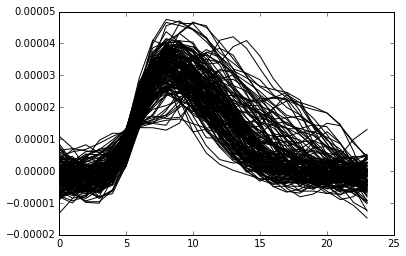

In [24]:
for i in range(len(label1)):
    if label1[i] == 1:
        plt.plot(thresholds_array[:,i], color = 'black')

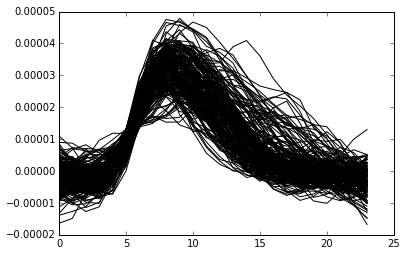

In [25]:
for i in range(len(label)):
    if label[i] == 1:
        plt.plot(thresholds_array[:,i], color = 'black')